In [1]:
from PIL import ImageFont, ImageDraw, Image, ImageOps

from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from pke.unsupervised import YAKE
from nltk.corpus import stopwords

import face_recognition 
import numpy as np
import random

import os
import shutil

/home/furiousteabag/programms/envs/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Making image from emoji 

## Methods to write text with set of pixels. 

In [2]:
def square_side_length(image,
                       back_ground_color=(0, 0, 0, 0)):
    """Square side length on picture with squares.

    Args:
        image: Picture with squares on it.
               Squares are similar to each other.
    """
    width, height = image.size
    lengthes = []
    for h in range(height):
        counter = 0
        for w in range(width):
            pixel_color = image.getpixel((w, h))
            if (pixel_color != back_ground_color):
                counter += 1
        if (len(set(lengthes)) < 3):
            lengthes.append(counter)
    return len(list(filter(lambda x: x != 0, lengthes[:-1])))

In [3]:
def squeeze_squares_into_pixels(image,
                                back_ground_color=(0, 0, 0, 0)):
    """Squeezing squares on image into 1 top left pixel.

    Args:
        image: Picture with squares on it.
               Squares are similar to each other.
    """
    width, height = image.size
    side_length = square_side_length(image)
    for w in range(width):
        for h in range(height):
            pixel_color = image.getpixel((w, h))
            if pixel_color != back_ground_color:
                for w_black in range(w, w + side_length):
                    for h_black in range(h, h + side_length):
                        if (w_black != w or h_black != h):
                            image.putpixel((w_black, h_black), back_ground_color)
    return image

## Methods to generate pictures. 

In [4]:
def write_text_with_squares(phrase,
                            width,
                            height,
                            back_ground_color,
                            margin,
                            font_path,
                            font_size,
                            font_color):
    """Drawing given text with given params.

    Args:
        phrase (int): What text to draw.

    Returns:
        image, font_size.
    """
    image = Image.new("RGBA", (width, height), back_ground_color)

    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(font_path, font_size)
    draw.text(margin, phrase, font=font, fill=font_color)

    return image, font_size

In [5]:
def write_text_with_squares_not_dependent(phrase,
                                          height=1000,
                                          back_ground_color=(0, 0, 0, 0),
                                          font_color=(0, 0, 0),
                                          font_path="../support_files/fonts/EnhancedDotDigital7-XyLK.ttf"):
    """Shell for write_text_with_squares method.
    """

    width = int(height*2)
    font_size = int(3000/len(phrase))
    margin = (int(width/font_size)*25, int(height/font_size)*150)

    return write_text_with_squares(phrase=phrase,
                                   height=height,
                                   width=width,
                                   back_ground_color=back_ground_color,
                                   font_color=font_color,
                                   font_size=font_size,
                                   margin=margin,
                                   font_path=font_path)

In [6]:
def prepare_emoji_list(emoji_list,
                       font_size):
    """Preparing emojies to be put on picture.
    """

    return list(map(lambda x: x.convert("RGBA").resize((int(font_size/10), int(font_size/10))), emoji_list))

In [7]:
def fill_text_with_emojies(emoji_list,
                           image,
                           back_ground_color=(0, 0, 0, 0)):
    """Filling every pixel which color in not back_ground_color with random emoji.
    """

    image = squeeze_squares_into_pixels(image)

    out = Image.new('RGBA', image.size, back_ground_color)
    width, height = image.size
    for x in range(width):
        for y in range(height):
            if image.getpixel((x, y)) != back_ground_color:
                random_num = random.randint(0, len(emoji_list)-1)
                img_to_paste = emoji_list[random_num]
                out.paste(img_to_paste, (x, y), mask=img_to_paste)

    return out

In [8]:
def write_text_with_emojies(text,
                            emoji_list,
                            output_dir,
                            i=0):
    """Writing given text with given emojies, saving them.
    """

    image, font_size = write_text_with_squares_not_dependent(text)

    emoji_list = list(map(lambda x: Image.open(x), emoji_list))
    emoji_list = prepare_emoji_list(emoji_list, font_size)
    out = fill_text_with_emojies(emoji_list, image)

    out.save(output_dir+str(i)+text+".png", "PNG")

    return out

In [9]:
def write_text_with_faces(text,
                          pictures_to_write_missing_letters_with_path,
                          output_dir,
                          i=0):
    """Writing given text with given faces, saving them.
    """

    pictures_paths_list = list(map(lambda x: pictures_to_write_missing_letters_with_path + x,
                                   os.listdir(pictures_to_write_missing_letters_with_path)))
    pictures_paths_list = list(map(lambda x: crop_face(Image.open(x)), pictures_paths_list))
    pictures_paths_list = list(map(lambda x: make_circled_image(x), pictures_paths_list))

    image, font_size = write_text_with_squares_not_dependent(text)
    pictures_paths_list = prepare_emoji_list(pictures_paths_list, font_size)

    out = fill_text_with_emojies(pictures_paths_list, image)
    out.save(output_dir+str(i)+text+".png", "PNG")

    return out

## Cropping face 

In [10]:
def crop_face(img):
    """Returns face from image.
    """

    img_array = np.array(img)
    face_locations = face_recognition.face_locations(img_array)

    x = face_locations[0][3]
    y = face_locations[0][0]
    max_x = face_locations[0][1]
    max_y = face_locations[0][2]

    cut = img.crop((x, y, max_x, max_y))

    return cut

In [11]:
def make_circled_image(img):
    """Making image circled.
    """

    im = img.resize((120, 120))
    bigsize = (im.size[0] * 3, im.size[1] * 3)
    mask = Image.new('L', bigsize, 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0) + bigsize, fill=255)
    mask = mask.resize(im.size, Image.ANTIALIAS)
    im.putalpha(mask)

    output = ImageOps.fit(im, mask.size, centering=(0.5, 0.5))
    output.putalpha(mask)

    return output

## Tokenization and emoji pictures 

### Tokenization 

In [12]:
def get_kphrases(text, n=100):
    """Return key phrases for input text
    """

    tokenizer = RegexpTokenizer(r'\w+')
    text_split = tokenizer.tokenize(text)
    extractor = YAKE()
    try:
        # load the content of the document, here document is expected to be in raw
        # format (i.e. a simple text file) and preprocessing is carried out using spacy
        extractor.load_document(text, language='en')

        # keyphrase candidate selection, in the case of TopicRank: sequences of nouns
        # and adjectives (i.e. `(Noun|Adj)*`)
        extractor.candidate_selection(n=1)

        # candidate weighting, in the case of TopicRank: using a random walk algorithm
        extractor.candidate_weighting()

        # N-best selection, keyphrases contains the 10 highest scored candidates as
        # (keyphrase, score) tuples
        keyphrases = extractor.get_n_best(n=n)

        phrases = []
        for phrase, _ in keyphrases:
            phrases.append(phrase)

        order_phrases = []
        for phrase in text_split:
            if phrase in phrases:
                order_phrases.append(phrase)
        return order_phrases

    except Exception:
        return []

### Emojies 

In [13]:
def norm(text):
    """Normilizing word.
    """

    try:
        tokenizer = RegexpTokenizer(r'\w+')
        text = tokenizer.tokenize(text)
        lemmatizer = PorterStemmer()

        word_list = [lemmatizer.stem(textik).lower() for textik in text]

        filtered_words = [word for word in word_list if word not in stopwords.words('english')]
        return filtered_words

    except Exception:
        return []


def get_filename(file):
    """Getting list of tags from emoji name.
    """

    try:
        base = os.path.basename(format(file))
        return norm(' '.join(os.path.splitext(base)[0].split('_')))

    except Exception:
        return []


def get_emoji(word, file_path="../support_files/emoji/"):
    """Getting list of paths to emojies containing given word.
    """

    try:
        lis = []
        onlyfiles = [f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]
        for file in onlyfiles:
            if norm(word)[0] in get_filename(file):
                lis.append(file_path+file)
        return lis
    except Exception:
        return []

## Testing 

### Text with emojies 

In [14]:
text = "LOVE"
emoji_list = ["../support_files/emoji/kiss_kissu.png", 
              "../support_files/emoji/kiss_kissu_love_love_loving.png",
              "../support_files/emoji/kiss_whistle.png",
              "../support_files/emoji/love_loveu_beautiful_lovely_sexy_attractive_sweetheart_likable_cute_lovable_sweet.png",
              "../support_files/emoji/loveu_love_arrow_loving_smitten_heart.png",
              "../support_files/emoji/love_beat_loveu_loving_beating_vibrating_lovely_heart.png",]

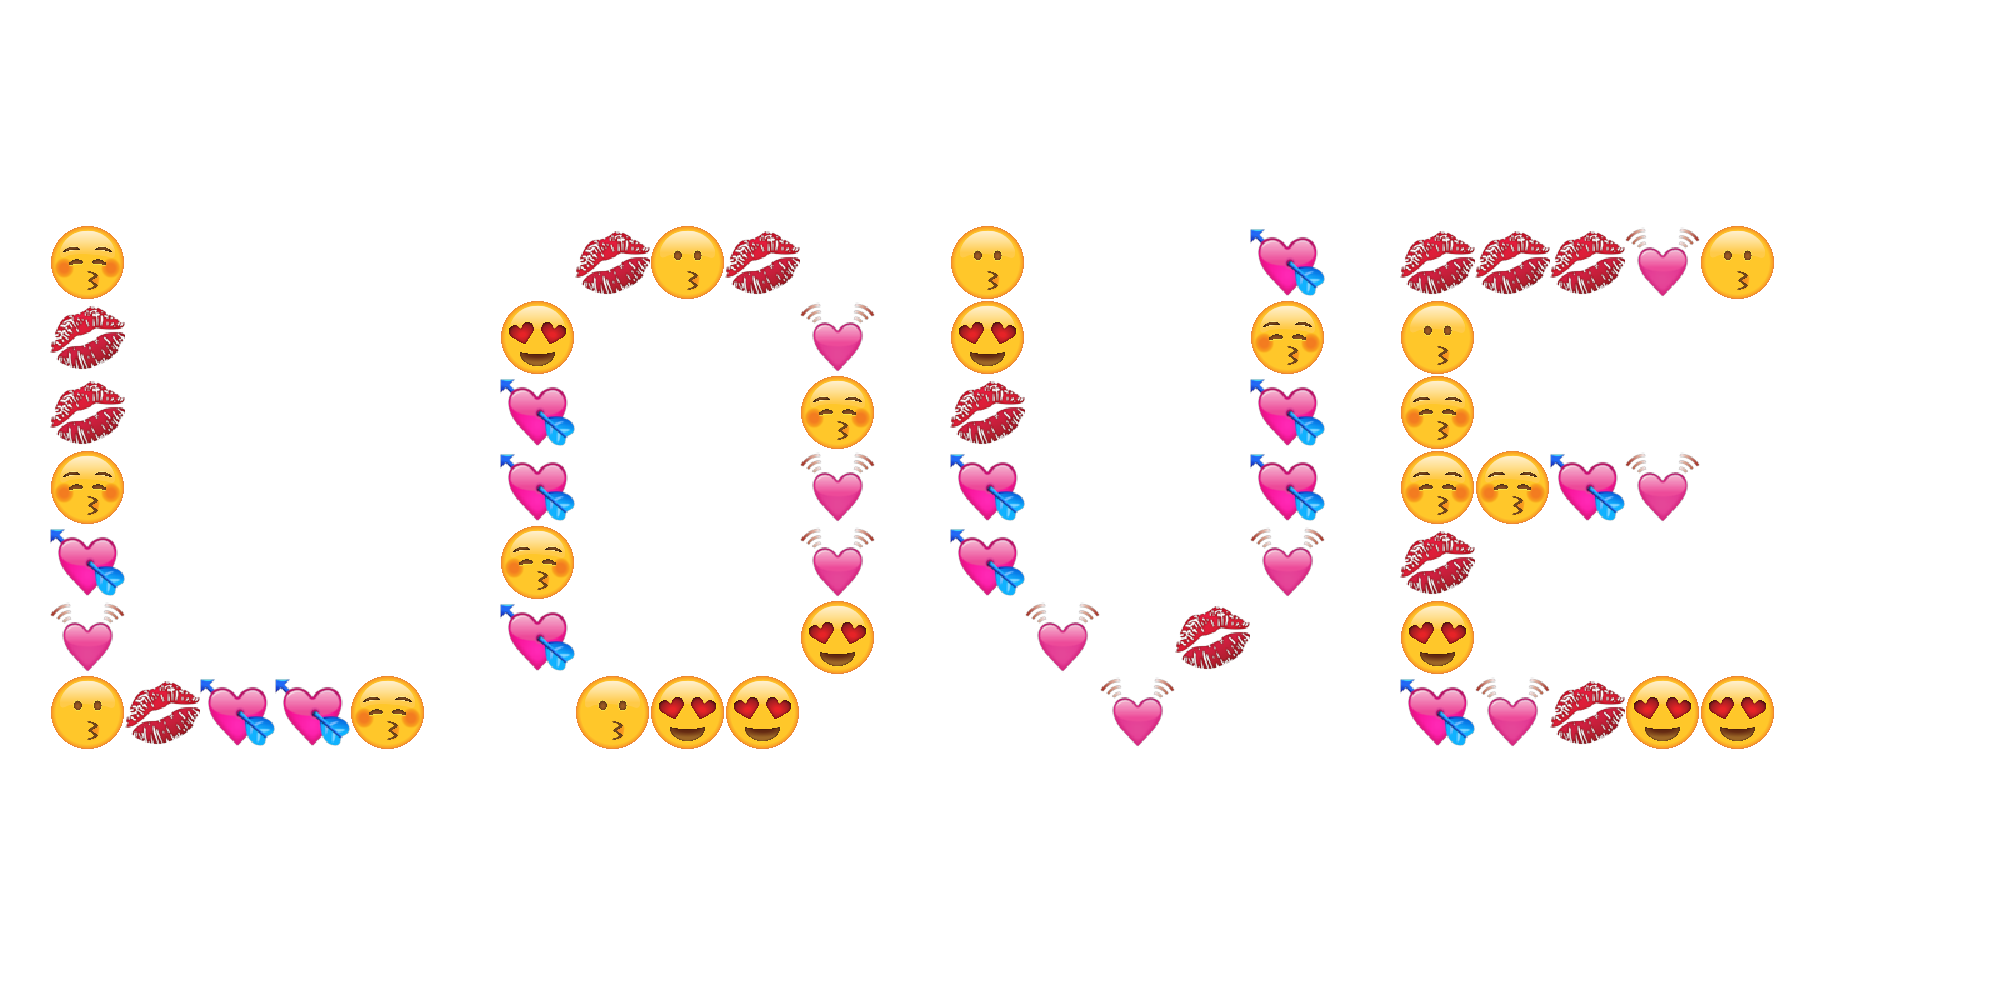

In [15]:
out = write_text_with_emojies(text=text, 
                              emoji_list=emoji_list, 
                              output_dir="../output/")
out

### Text with face 

In [16]:
text = "HEY"
pictures_to_write_missing_letters_with_path = "../support_files/pictures_to_write_letters/"

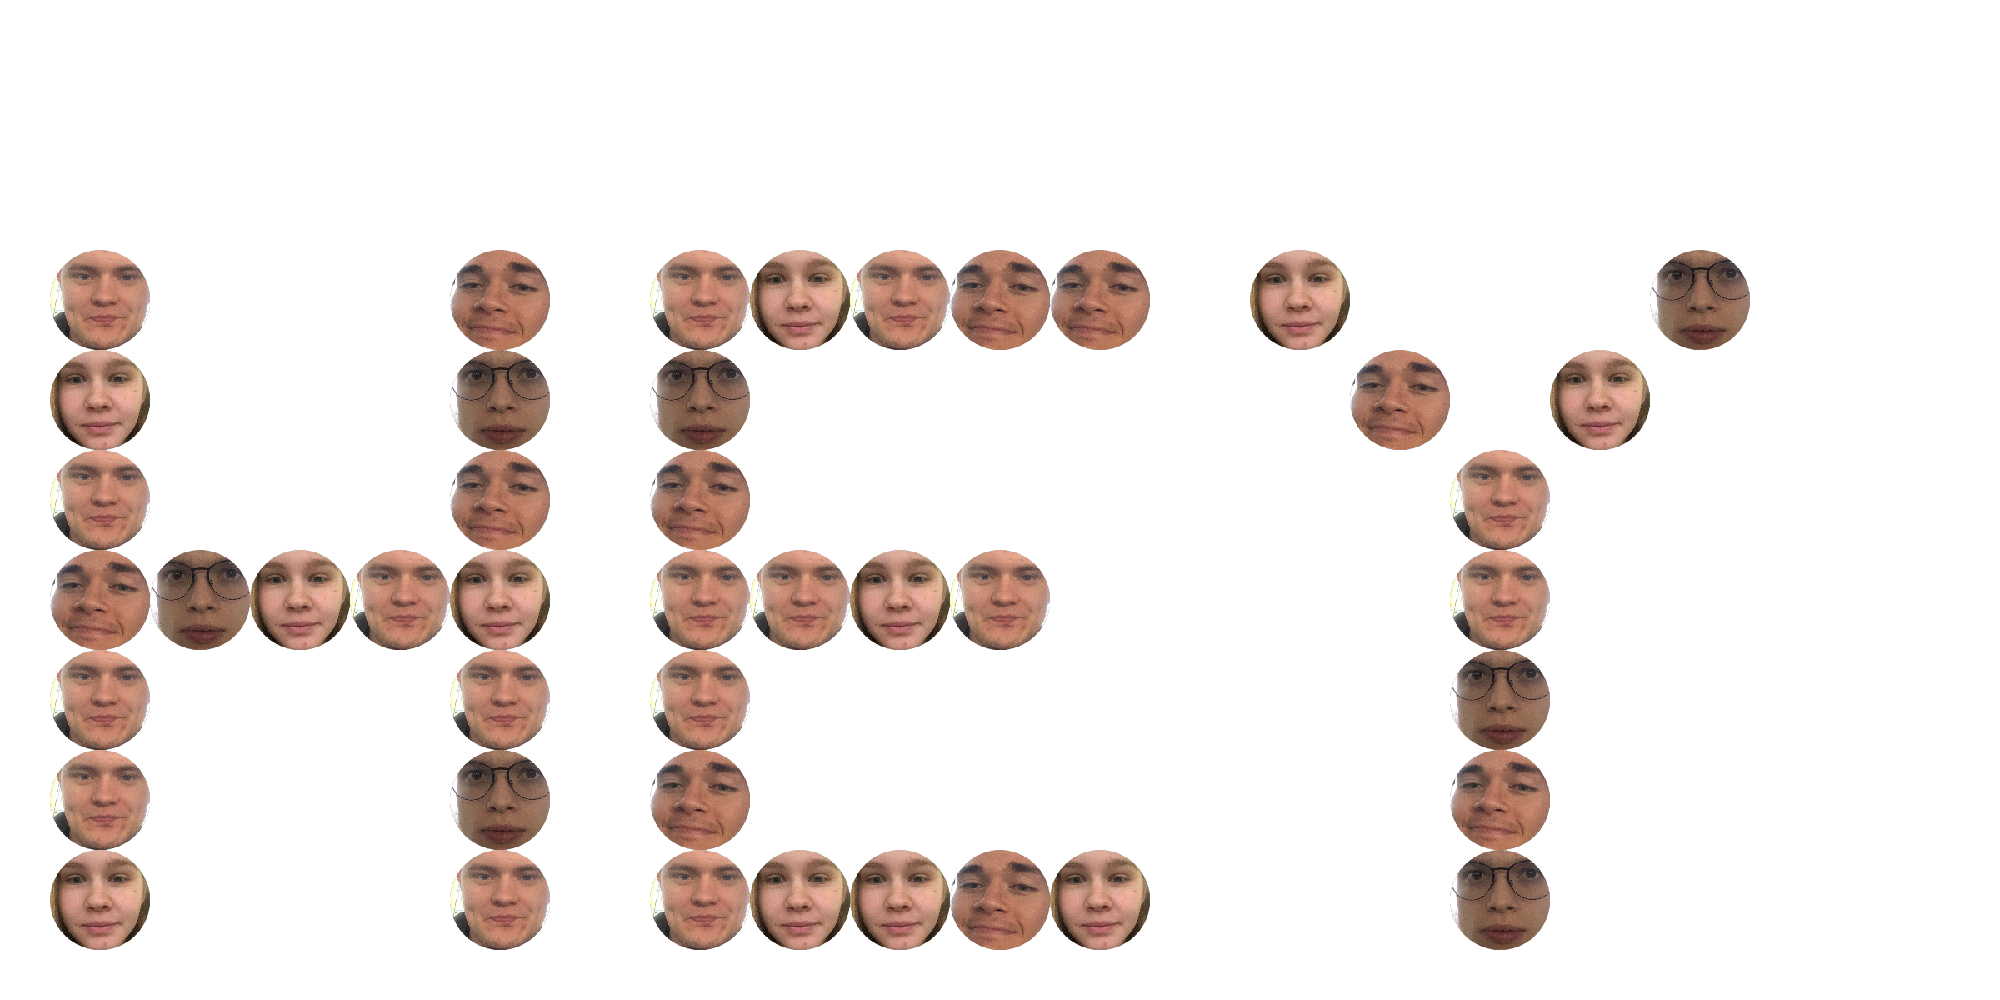

In [17]:
out = write_text_with_faces(text=text, 
                            pictures_to_write_missing_letters_with_path=pictures_to_write_missing_letters_with_path,
                            output_dir="../output/")
out

# Making emoji text backgroung

In [18]:
def make_trasparent(image, rate):
    """Making .png image transparent with given rate
    """

    # Load the image and make into Numpy array
    rgba = np.array(image)

    # Make image transparent white anywhere it is transparent
    rgba[rgba[..., -1] == 0] = [255, 255, 255, 0]

    # Make back into PIL Image and save
    rgba_image = Image.fromarray(rgba)

    rgba_image.putalpha(rate)

    rgba_image = rgba_image.convert("RGBA")
    datas = rgba_image.getdata()

    newData = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)

    rgba_image.putdata(newData)

    return rgba_image

In [19]:
def resizer(image_to_be_put, image):
    """Resizing image_to_be_put so it fits into image.
    """

    r = random.randint(4, 10)
    width_img, height_img = image.size
    width_arrow, height_arrow = image_to_be_put.size
    if (int(width_arrow * r) < int(width_img * 0.5)) or (int(height_arrow * r) < int(height_img * 0.5)):
        new_size = (int(width_arrow * r), int(height_arrow * r))
        print(r)
        image_to_be_put = image_to_be_put.resize(new_size)

        return image_to_be_put
    else:
        resizer(image_to_be_put, image)


def image_maker(image_to_be_put, image):
    """Imposing image_to_be_put to image with random angle and random location.
    """

    resized_arrow = resizer(image_to_be_put, image)
    resized_arrow = make_trasparent(resized_arrow, 100)

    width_img, height_img = image.size

    rangle = random.randint(0, 360)
    new_arrow = resized_arrow.rotate(rangle, expand=True)
    width_new_arrow, height_new_arrow = new_arrow.size
    rx = random.randint(0, height_img - height_new_arrow)
    ry = random.randint(0, width_img - width_new_arrow)

    area = (ry, rx)
    try:
        image.paste(new_arrow, area, new_arrow)
    except Exception:
        print("Not Today.")

    return image


def put_images_onto_image(images_list, image, num_of_images):
    """Placing images on image.
    """

    for i in range(num_of_images):
        random_num = random.randint(0, len(images_list)-1)
        image_to_be_put = images_list[random_num]
        image = image_maker(image_to_be_put, image)
    return image


def put_images(images_paths, image_path, num_of_images):
    """Shell for put_images_onto_image method.
    """

    images_list = list(map(lambda x: Image.open(x), images_paths))
    images_list = list(map(lambda x: x.resize((60, 60)), images_list))
    image = Image.open(image_path)
    return put_images_onto_image(images_list=images_list,
                                 image=image,
                                 num_of_images=num_of_images)

In [20]:
images_paths = ["../support_files/emoji/kiss_kissu.png", 
                "../support_files/emoji/kiss_kissu_love_love_loving.png",
                "../support_files/emoji/kiss_whistle.png",
                "../support_files/emoji/love_loveu_beautiful_lovely_sexy_attractive_sweetheart_likable_cute_lovable_sweet.png",
                "../support_files/emoji/loveu_love_arrow_loving_smitten_heart.png",
                "../support_files/emoji/love_beat_loveu_loving_beating_vibrating_lovely_heart.png",]
image_path = "../output/0LOVE.png"
num_of_images = 5

9
9
10
6
8


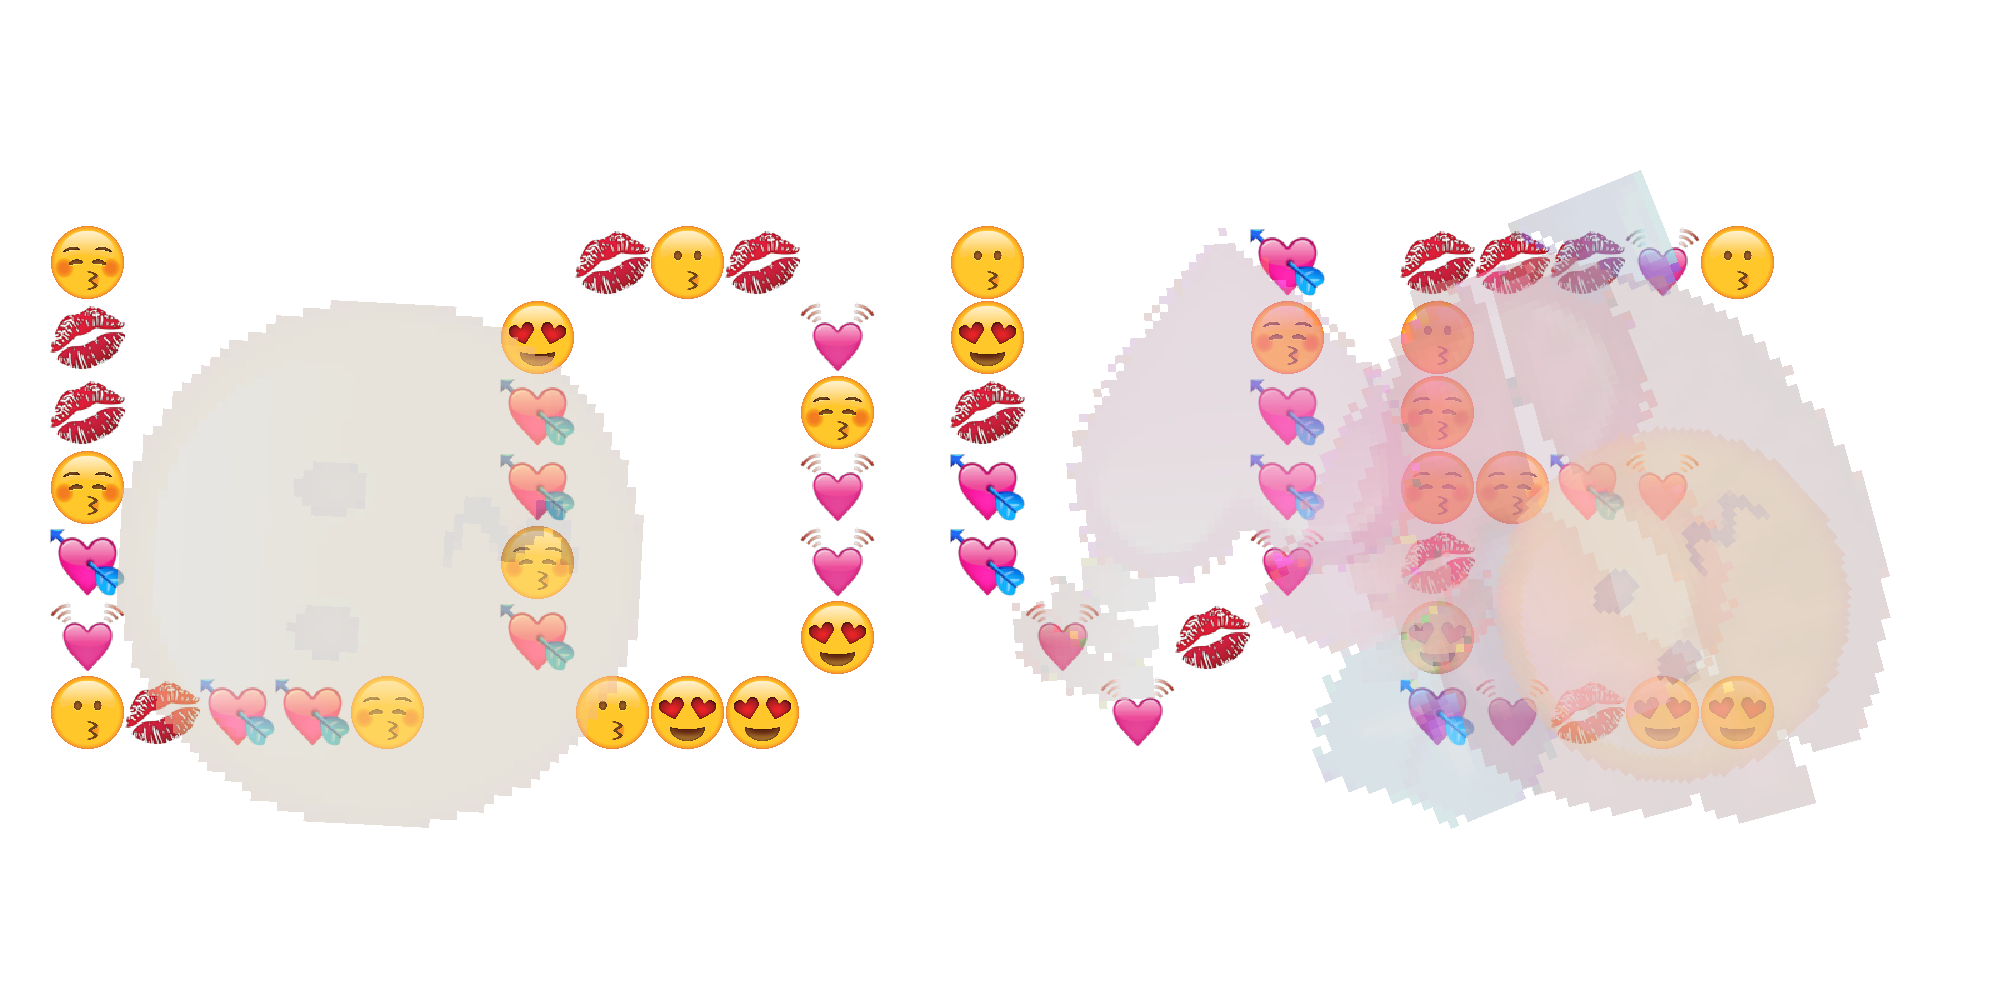

In [21]:
result_image = put_images(images_paths=images_paths, 
                          image_path=image_path, 
                          num_of_images=num_of_images)
result_image

# Creating gif 

In [22]:
def clear_dir(dir_path):
    for the_file in os.listdir(dir_path):
        file_path = os.path.join(dir_path, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(e)

In [23]:
def gen_frame(path):
    """Preparing image for a transparent gif.
    """
    im = Image.open(path)
    alpha = im.getchannel('A')

    # Convert the image into P mode but only use 255 colors in the palette out of 256
    im = im.convert('RGB').convert('P', palette=Image.ADAPTIVE, colors=255)

    # Set all pixel values below 128 to 255 , and the rest to 0
    mask = Image.eval(alpha, lambda a: 255 if a <= 128 else 0)

    # Paste the color of index 255 and use alpha as a mask
    im.paste(255, mask)

    # The transparency index is 255
    im.info['transparency'] = 255

    return im

In [24]:
def generate_gif(text="Sweetheart, I miss you so much",
                 pictures_to_write_missing_letters_with_path="../support_files/pictures_to_write_letters/",
                 output_dir="../output/",
                 emoji_dir="../support_files/emoji/"):
    """Generating .gif from given text.
    """

    clear_dir(output_dir)

    word_list = get_kphrases(text)
    word_list = list(map(lambda x: x.upper(), word_list))

    print("Main words: {}".format(word_list))

    # Adding pictures that will be used for gif.
    for i in range(len(word_list)):

        emoji_list = get_emoji(word_list[i], emoji_dir)

        if emoji_list == []:
            write_text_with_faces(text=word_list[i],
                                  i=i,
                                  pictures_to_write_missing_letters_with_path=pictures_to_write_missing_letters_with_path,
                                  output_dir=output_dir)
        else:
            write_text_with_emojies(text=word_list[i],
                                    emoji_list=emoji_list,
                                    i=i,
                                    output_dir=output_dir)

    print("Succesfully prepared words for .gif, exported in directory: '{}'.".format(output_dir))

    # Making gif.
    filenames = os.listdir(output_dir)
    filenames = list(map(lambda x: output_dir + x, filenames))
    filenames.sort()

    if filenames != []:
        filenames = list(map(lambda x: gen_frame(x), filenames))
        im1 = filenames[0]
        im1.save(output_dir + 'output.gif', save_all=True,
                 append_images=filenames[1:], loop=0, duration=1500, disposal=2)

    print("Succesfully prepared .gif, exported in directory: '{}'.".format(output_dir))

In [25]:
test1 = "I'll kill you if you don't get the phone"
test2 = "Sweetheart, I miss you so much"
test3 = "I am terribly sorry, but we have to re-schedule the meeting again"
test4 = "I'm so happy! Summer is finally back to town!"
test5 = "I'm stuck in a traffic jam and will be late, all is lost"
test6 = "Fuck you!"
test7 = "Mama always said life was like a box of chocolates. You never know what you're gonna get."
test8 = "Wow! That's cool!"

In [26]:
generate_gif(test1)

Main words: ['KILL', 'GET', 'PHONE']
Succesfully prepared words for .gif, exported in directory: '../output/'.
Succesfully prepared .gif, exported in directory: '../output/'.
